In [1]:
# example parameters
directory = '../../output.demo'
name = 'GCA_002691795'
databases = "gtdb-genus-n0.protein-k11-scaled100,gtdb-genus-n0.nucleotide-k21-scaled1000,gtdb-genus-n0.dayhoff-k19-scaled100"
render='svg'

In [2]:
if not render: render_name = None
else: render_name = render

In [3]:
import os.path
import collections
import csv

import plotly.graph_objects as go

import sourmash
from thumper import charcoal_utils as utils
from thumper.figs.sourmash_sankey import GenomeSankeyFlow

In [4]:
from IPython.display import Markdown as md
from IPython.display import display
md(f"# Thumper contig summary report for genome `{name}`")

# Thumper contig summary report for genome `GCA_002691795`

In [5]:
import os
from thumper import charcoal_utils as utils

In [87]:
dbs = databases.split(',')
genome_rankgather_csv = f'{directory}/genome-search/{name}.x.{dbs[0]}.rankgather.csv'
#contig_rankgather_csv = f'{directory}/contig-search/{name}.x.{database}.contigs.rankgather.csv'
#contig_rankgather_json = f'{directory}/contig-search/{name}.x.{database}.contigs.rankgather.json'
#summary = utils.CSV_DictHelper(summary_csv, 'genome')

In [88]:
#summary = utils.CSV_DictHelper(summary_csv, 'genome')
#row = summary[name]
#genome_lineage = utils.make_lineage(row.lineage)

## read genome csv using csv instead of pandas
genome_info = ""
genome_lineage = ""
with open(genome_rankgather_csv, 'r') as fp:
    r = csv.DictReader(fp)
    for row in r:
        if (row["match_rank"] == "genus"):
            genome_lineage = utils.make_lineage(row["lineage"])
            break
#print(genome_lineage)

In [89]:
#import pandas as pd
#genome_info = pd.read_csv(genome_rankgather_csv, index_col=["match_rank"])
#genome_info
#genome_lineage = utils.make_lineage(genome_info.at["genus", "lineage"])
#contig_info = pd.read_csv(contig_rankgather_csv, index_col=["name", "match_rank"])
#contig_info

## Taxonomic assignments across ranks

In [90]:
# start with charcoal fig functions
def make_plotly_fig(obj, title):
    "Build a plotly figure/sankey diagram."
    # make the data to go into the sankey figure.
    labels = obj.make_labels()
    src_l, dest_l, cnt_l, color_l, label_l = obj.make_lists()

    # build figure
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 10,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = "blue"
        ),
        link = dict(
          source = src_l,
          target = dest_l,
          value = cnt_l,
          color = color_l,
          label = label_l,
      ))])

    if title:
        fig.update_layout(title_text=title, font_size=10)

    return fig

In [91]:
def make_flow_fig(title, genome_lineage, contigs_info, best_only=True):
    obj = GenomeSankeyFlow()
    
    counts = collections.Counter()
    for contig_name, gather_info in contigs_info.items():
        contig_taxlist = gather_info.gather_tax

        # iterate over each contig match and summarize counts.              
        # note - here we can stop at first one, or track them all.          
        # note - b/c gather counts each hash only once, these               
        #     are non-overlapping                                           
        total_hashcount = 0
        for lin, hashcount in contig_taxlist:
            counts[lin] += hashcount
            total_hashcount += hashcount
            if best_only:
                break # display only first

        # track missing => unassigned lineage
        unident = gather_info.num_hashes - total_hashcount
        counts[obj.unassigned_lin] += unident

    # extend genome_lineage ranks
    last_genome_rank = genome_lineage[-1].rank
    taxlist = list(sourmash.lca.taxlist())[:-2]
    assert taxlist[-1] == 'genus', taxlist
    
    if genome_lineage[-1].rank != 'genus':
        genome_lineage = list(genome_lineage)
        for rank in taxlist[len(genome_lineage):]:
            genome_lineage.append(sourmash.lca.LineagePair(rank=rank, name='unassigned'))
    
    # set the color of the main lineage
    genome_lineage = tuple(genome_lineage)
    obj.colors[genome_lineage] = "lightseagreen"
    
    # for phylum level disagreements, let's go with palevioletred
    for lin in counts:
        if not utils.is_lineage_match(lin, genome_lineage, 'phylum'):
            obj.colors[lin] = 'palevioletred'
            
    # assign unassigned to good lineage, maybe?
    counts[genome_lineage] += counts[obj.unassigned_lin]
    del counts[obj.unassigned_lin]
    
    obj.make_links(genome_lineage, counts)
    fig = make_plotly_fig(obj, title)
    
    return fig

### These alluvial flow diagrams contain the annotation information gathered for each contig.

#### The first set of diagrams displays the best-hit annotation from each contig.

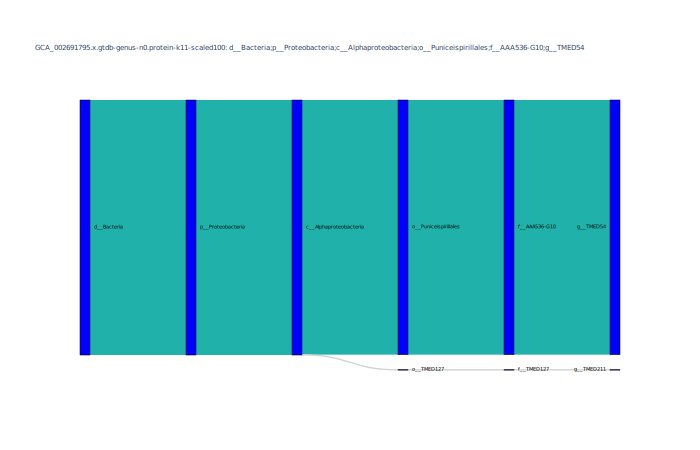

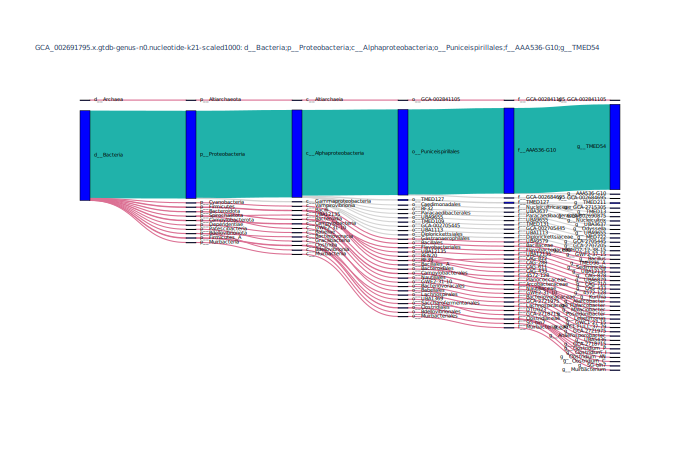

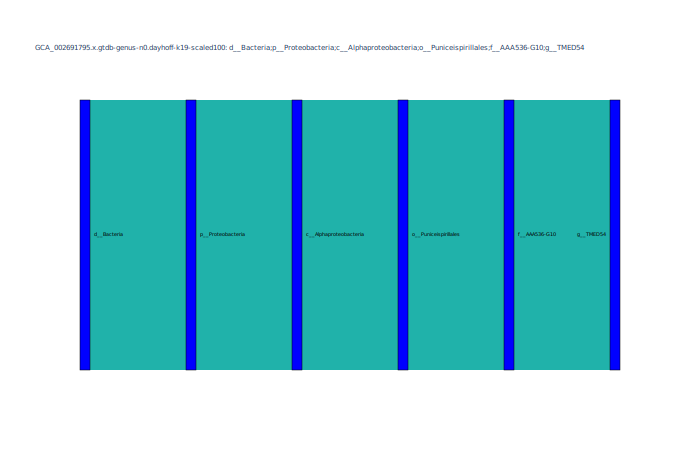

In [92]:
for database in dbs:
    contig_gather_json = f'{directory}/contig-search/{name}.x.{database}.contigs.gather.json'
    contigs_info = utils.load_contigs_gather_json(contig_gather_json)
    title = name + ".x." + database +": " + sourmash.lca.display_lineage(genome_lineage)
    fig = make_flow_fig(title, genome_lineage, contigs_info)
    fig.show(render_name)


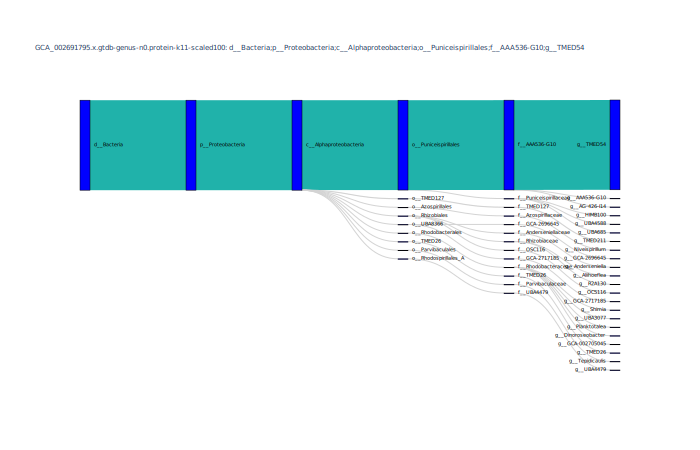

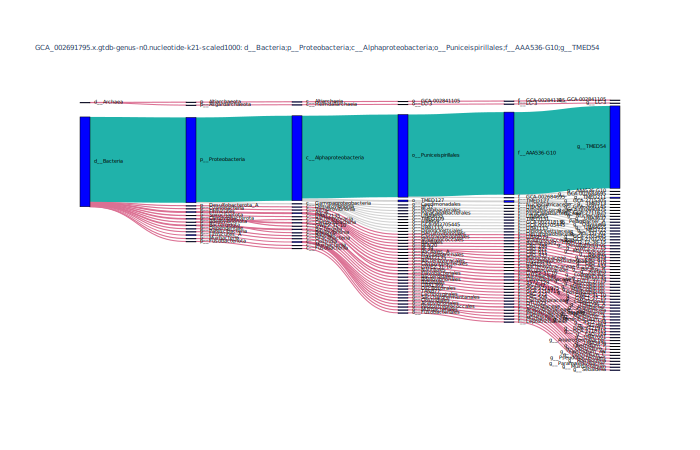

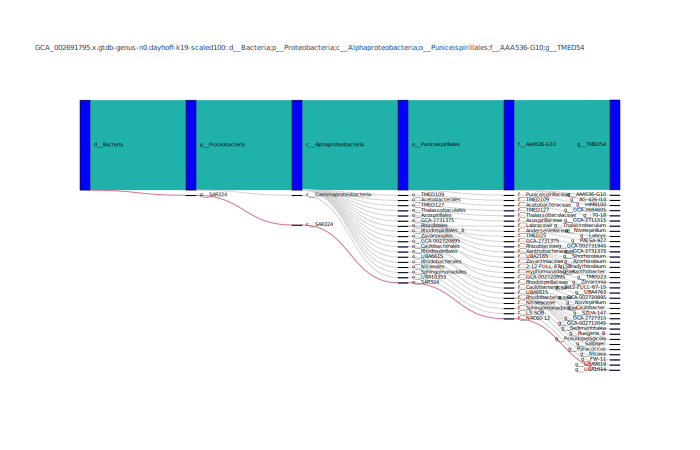

In [93]:
#### The second set of diagrams would display all non-overlapping gather matches for each contig.
#for database in dbs:
#    contig_rankgather_json = f'{directory}/contig-search/{name}.x.{database}.contigs.gather.json'
#    contigs_info = utils.load_contigs_gather_json(contig_rankgather_json)
#    title = name + ".x." + database +": " + sourmash.lca.display_lineage(genome_lineage)
#    fig = make_flow_fig(title, genome_lineage, contigs_info, best_only=False)
#    fig.show(render_name)